In [42]:
import numpy as np
import pandas as pd
import pickle as pkl
from concurrent.futures import ThreadPoolExecutor
import os
from matplotlib import pyplot as plt
from data_generation_sty import *
import glob
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [85]:
# TODO: Hyperparameters search for omp

##* Data Generation
##* N (columns of dictionary) = 10k
##* d (dimension of signal) = 300, 600, 900, 1200, 1500, 2000
##* X_{ij} \sim N(0, \frac{1}{n}) (The same as N(0,1) them normalize)
##* m (sparse level) = 20, 40, 80

##* Noise level = 0.01, 0.05, 0.1, 0.2, 0.5

N = 1000
d = 400
m = 40
noise_level_lst = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
trial_num = 10
cv_num = 5
np.arange(0.02, 0.30, 0.04)

array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26])

In [86]:
##! Task 1: Given signal, dictionary, sparsity level and noise level, use testset (10% of the whole signal) to find the best K(depth) for omp


seed = 0
Data_Geneartor = GaussianDataGenerator(N, d, m, 0.05, seed)

true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()

In [87]:
def cv_split(true_signal, dictionary, cv_num):
    true_signal = true_signal.ravel()
    # true_signal is (1200, 1) and dictionary is (1200, 10000), cv both signal and dictionary by rows
    cv_signal = np.split(true_signal, cv_num)
    cv_dictionary = np.split(dictionary, cv_num)
    # Get the list of train and test set
    cv_res = []
    for i in range(cv_num):
        train_signal = np.concatenate(cv_signal[:i] + cv_signal[i + 1:], axis = 0)
        train_dictionary = np.concatenate(cv_dictionary[:i] + cv_dictionary[i + 1:], axis=0)
        test_signal = cv_signal[i]
        test_dictionary = cv_dictionary[i]
        cv_res.append((train_signal, train_dictionary, test_signal, test_dictionary))
    return cv_res

In [88]:
# We need a OMP class to do the cross validation and it need a fit and score function

# ? The algorithm is not optimized, it is just for a quick demonstration
def cal_cv_error(algorithm, cv_num, signal, dictionary):
    cv_res = cv_split(signal, dictionary, cv_num)
    error_lst = []
    for i in range(cv_num):
        train_signal, train_dictionary, test_signal, test_dictionary = cv_res[i]
        algorithm.fit(train_signal, train_dictionary)
        error_lst.append(algorithm.score(test_signal, test_dictionary))
    return np.mean(error_lst)

In [89]:
from algorithms import OMP

cal_cv_error(OMP(10), 10, perturbed_signal, dictionary)

0.008747094751730794

In [90]:
##! Task 2: Relationship between best K and noise level (std)

##! Task 3: Relationship between Test Error and noise level (std)

# Choose the best K for each noise level

def cv_best_K(signal, dictionary, cv_num, K_lst):
    K_cv_error = []
    for K in K_lst:
        OMP_tmp = OMP(K, ignore_warning=True)
        K_cv_error.append(cal_cv_error(OMP_tmp, cv_num, signal, dictionary))
    lowest_error = np.min(K_cv_error)
    lowest_error_K = K_lst[np.argmin(K_cv_error)]
    return lowest_error, lowest_error_K, K_cv_error

cv_best_K(perturbed_signal, dictionary, 5, np.arange(2, 22, 2))

(0.004461024759454469,
 20,
 [0.05947082234212871,
  0.036164413066568035,
  0.023039263490360225,
  0.015951317772609296,
  0.01362105217308555,
  0.010723810868502031,
  0.008335429787357834,
  0.0064280226848570324,
  0.005708409682357732,
  0.004461024759454469])

In [91]:
# Improvement: Save the result to a file

if not os.path.exists('./memory_sty'):
    os.mkdir('./memory_sty')

def cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, K_lst, trial_num, output_filename = None):
    if output_filename is None:
        output_filename = str(N) + '_' + str(d) + '_' + str(m) + '_' + str(trial_num) + '_' + str(cv_num) + '.pkl'
    res_log = {
        'parameters': {'N': N, 'd': d, 'm': m, 'noise_level_lst': noise_level_lst, 'cv_num': cv_num, 'trial_num': trial_num, 'K_lst': K_lst},
        'noise_level_best_K': [],
        'noise_level_lowest_MSE': [],
        'log': []
    }
    noise_level_best_K = []
    noise_level_lowest_MSE = []
    for noise_level in noise_level_lst:
        print("Cross validating K under noise level: ", noise_level)
        trials_best_K_tmp = []
        MSE_loweset_K_temp = []
        for trial in range(trial_num):
            Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, trial)
            true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
            lowest_error, lowest_error_K, cv_err_lst = cv_best_K(perturbed_signal, dictionary, cv_num, K_lst)
            trials_best_K_tmp.append(lowest_error_K)
            MSE_loweset_K_temp.append(lowest_error)
            print("Trial: ", trial, " Best K: ", lowest_error_K, " Lowest Error: ", lowest_error)
            log_tmp = {'noise_level': noise_level, 'trial': trial, 'data': Data_Geneartor, 'cv_error_lst': cv_err_lst, 
                       'lowest_error': lowest_error, 'lowest_error_K': lowest_error_K}
            res_log['log'].append(log_tmp)
        noise_level_best_K.append(np.mean(trials_best_K_tmp))
        noise_level_lowest_MSE.append(np.mean(MSE_loweset_K_temp))
        print("Average best K for noise level: ", noise_level, " is: ", np.mean(trials_best_K_tmp), " with MSE: ", np.mean(MSE_loweset_K_temp))
    res_log['noise_level_best_K'] = noise_level_best_K
    res_log['noise_level_lowest_MSE'] = noise_level_lowest_MSE
    with open('./memory/' + output_filename, 'wb') as f:
        pkl.dump(res_log, f)
    print("Finished!")
    print("Log file saved to: ", './memory/' + output_filename)
    return noise_level_best_K, noise_level_lowest_MSE, res_log

In [92]:
# # Check if it is working
# N = 1000
# d = 500
# m = 20
# noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.3]
# trial_num = 5
# # ? Maybe we need to increase the trial number  
# cv_num = 5
# # ? Is cv necessary? 

# noise_level_best_K, noise_level_lowest_MSE, res_log = cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, np.arange(1, 41, 1), trial_num, 'test.pkl')

In [93]:
# plt.plot(noise_level_lst, noise_level_best_K)
# plt.xlabel("Noise std")
# plt.ylabel("Best iteration number")

In [94]:
# plt.plot(noise_level_lst, noise_level_lowest_MSE)
# plt.xlabel("Noise std")
# plt.ylabel("CV prediction error for best K")


In [95]:
# # extract noise level, trial, cv_error_lst from res_log

# tmp = []
# for i in range(len(res_log)):
#     tmp.append([res_log[i]['noise_level'], res_log[i]['trial'], res_log[i]['cv_error_lst']])
    
# K_lst = np.arange(1, 41, 1).tolist()


# fig, ax = plt.subplots()
# # Plot the cv error for each K for each noise level
# for i in range(len(tmp)):    
#     if i % trial_num == 0:
#         label = tmp[i][0]
#     else:
#         label = ""
#     # Assign color to different noise level
#     plt.plot(K_lst, tmp[i][2], label = label, color = plt.cm.Set2_r(i // trial_num))

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.get_legend().set_title("Noise std")

# plt.ylim([0, 0.01])

# plt.xlabel("Iteration number")
# plt.ylabel("CV prediction error")

It should be working, testing with the following parameters:

$$X \in \mathbb{R}^{n\times p}$$
$$p = 10000$$
$$n = 300, 600, 900, 1200, 1500, 2000$$
$$|\beta|_0 = 20, 40, 80$$
```

In [104]:
N = 1000
d = 600
m = 20
trial_num = 10
cv_num = 5
K_lst = np.arange(1, m+20+1, 1).tolist()

noise_level_best_K, noise_level_lowest_MSE, res_log = cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, K_lst, trial_num)

Cross validating K under noise level:  0
Trial:  0  Best K:  20  Lowest Error:  7.104929252597494e-32
Trial:  1  Best K:  22  Lowest Error:  5.40714904501893e-32
Trial:  2  Best K:  20  Lowest Error:  4.493916212400439e-32
Trial:  3  Best K:  20  Lowest Error:  5.962812510758443e-32
Trial:  4  Best K:  20  Lowest Error:  3.8791793786781606e-32
Trial:  5  Best K:  20  Lowest Error:  8.538221356667334e-32
Trial:  6  Best K:  20  Lowest Error:  2.739126423938073e-32
Trial:  7  Best K:  21  Lowest Error:  2.1220771155457524e-31
Trial:  8  Best K:  20  Lowest Error:  6.384248766666426e-32
Trial:  9  Best K:  21  Lowest Error:  4.5302450391878073e-32
Average best K for noise level:  0  is:  20.4  with MSE:  7.026059914137063e-32
Cross validating K under noise level:  0.05
Trial:  0  Best K:  22  Lowest Error:  0.0029877035603490015
Trial:  1  Best K:  18  Lowest Error:  0.002731871308515995
Trial:  2  Best K:  21  Lowest Error:  0.0031191257042347048
Trial:  3  Best K:  20  Lowest Error:  0.

In [109]:
def makeplots(res_log, sep=False, savefig = True, ylim = None):
    if not os.path.exists('./images'):
        os.makedirs('./images')
        
    # res_log can either be a object name or path to the file
    if isinstance(res_log, str):
        path = os.path.join('./memory/', res_log)
        with open(path, 'rb') as f:
            res_log = pkl.load(f)
    
    # Extract parameters
    parameters = res_log['parameters']
    noise_level_best_K = res_log['noise_level_best_K']
    noise_level_lowest_MSE = res_log['noise_level_lowest_MSE']
    
    K_lst = parameters['K_lst']
    trial_num = res_log['parameters']['trial_num']
    print('Parameters: ', parameters)
    
    # Get folder name for saving images
    imgfolderPath = str(parameters['N']) + '_' + str(parameters['d']) + '_' + str(parameters['m']) + '_' + str(parameters['trial_num']) + '_' + str(parameters['cv_num'])
    if savefig:
        if not os.path.exists('./images/' + imgfolderPath):
            os.makedirs('./images/' + imgfolderPath)
    
    # Generate plots
    ## First plot: Iteration number vs. CV prediction error for each noise level
    noise_level_lst = parameters['noise_level_lst']
    if sep:
        if not os.path.exists('./images/' + imgfolderPath + '/noise_sep'):
            os.makedirs('./images/' + imgfolderPath + '/noise_sep')
        # Plot the cv error for each K for each noise level in separate plots
        # Each noise level has trial_num trials and we put them in the same plot
        for i, noise_level in enumerate(noise_level_lst):
            fig, ax = plt.subplots()
            for j in range(trial_num):
                plt.plot(K_lst, res_log['log'][i * trial_num + j]['cv_error_lst'])
            plt.xlabel("Iteration number")
            plt.ylabel("CV prediction error")
            plt.title("CV prediction error\nn = " + str(parameters['d']) + ", p = " + str(parameters['N'])+ ", m = " + str(parameters['m'])+"\nNoise std: " + str(noise_level))    
            if savefig:
                plt.savefig('./images/' + imgfolderPath + '/noise_sep/' + str(noise_level) + '_' + str(j) + '.png')
            plt.show()
    # Plot all noise level together no matter whther sep or not
    tmp = []
    for i in range(len(res_log['log'])):
        tmp.append([res_log['log'][i]['noise_level'], res_log['log'][i]['trial'], res_log['log'][i]['cv_error_lst']])
    fig, ax = plt.subplots()
    # Plot the cv error for each K for each noise level
    for i in range(len(tmp)):    
        if i % trial_num == 0:
            label = tmp[i][0]
        else:
            label = ""
        # Assign color to different noise level
        plt.plot(K_lst, tmp[i][2], label = label, color = plt.cm.Set2_r(i // trial_num))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax.get_legend().set_title("Noise std")
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim([0, 0.5])
    
    plt.xlabel("Iteration number")
    plt.ylabel("CV prediction error")
    plt.title("CV prediction error for each noise level\n n = " + str(parameters['d']) + ", p = " + str(parameters['N'])+ ", m = " + str(parameters['m'])) 
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/cv_error.png', dpi=200, bbox_inches='tight')
    plt.show()

    ## Second plot: Noise std vs. best iteration number
    plt.plot(noise_level_lst, noise_level_best_K)
    plt.title("Best iteration number for each noise level\n n = " + str(parameters['d']) + ", p = " + str(parameters['N'])+ ", m = " + str(parameters['m']))
    plt.xlabel("Noise std")
    plt.ylabel("Best iteration number")
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/noise_vs_bestK.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    ## Third plot: Noise std vs. CV prediction error for best iteration number
    plt.plot(noise_level_lst, noise_level_lowest_MSE)
    plt.xlabel("Noise std")
    plt.ylabel("CV prediction error for best K")
    plt.title("CV prediction error for best iteration number for each noise level\n n = " + str(parameters['d']) + ", p = " + str(parameters['N']) + ", m = " + str(parameters['m']))
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/noise_vs_bestMSE.png', dpi=200, bbox_inches='tight')
    plt.show()

Parameters:  {'N': 1000, 'd': 600, 'm': 20, 'noise_level_lst': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 'cv_num': 5, 'trial_num': 10, 'K_lst': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


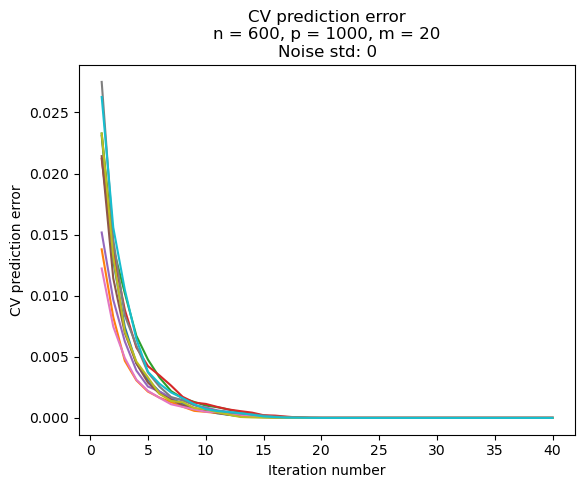

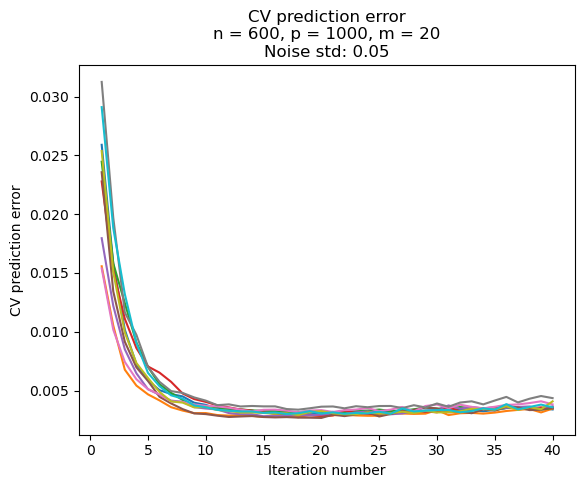

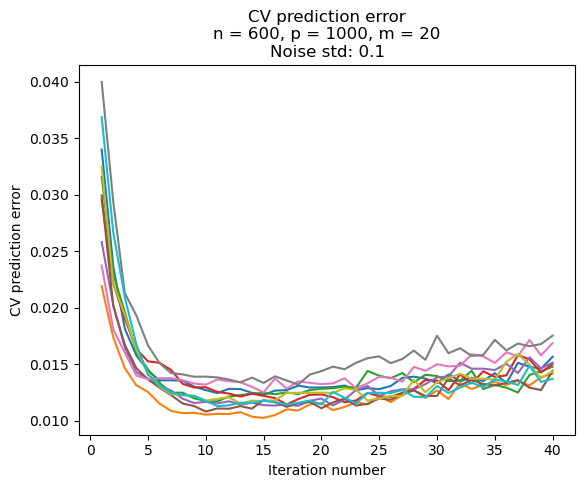

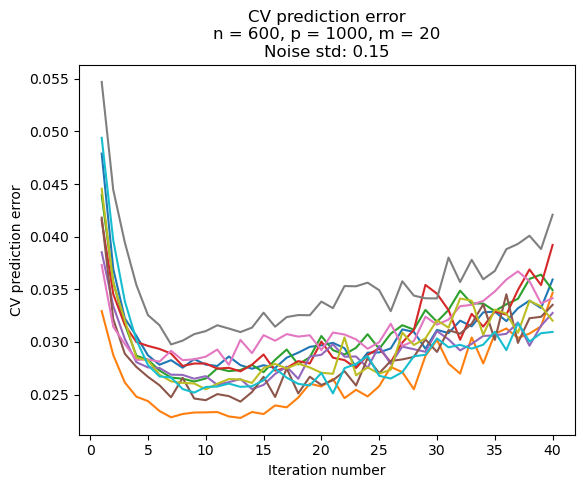

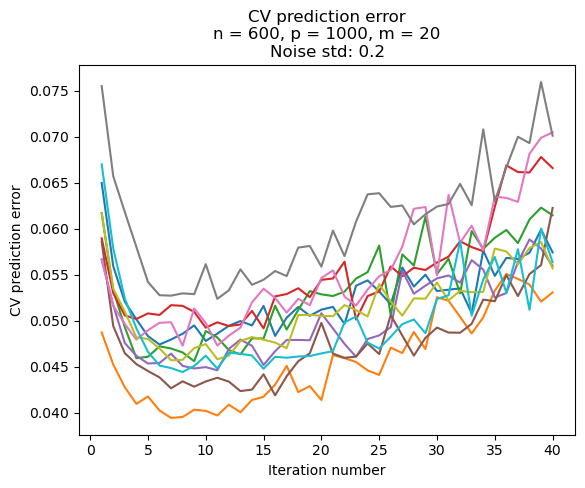

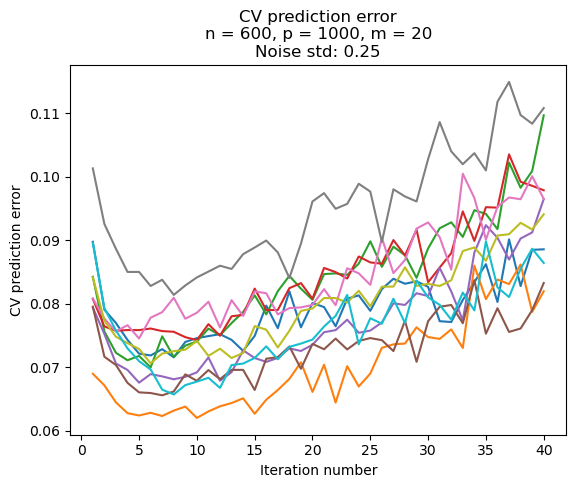

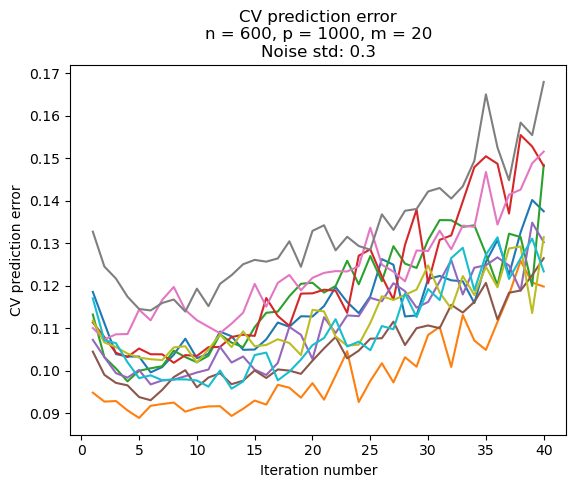

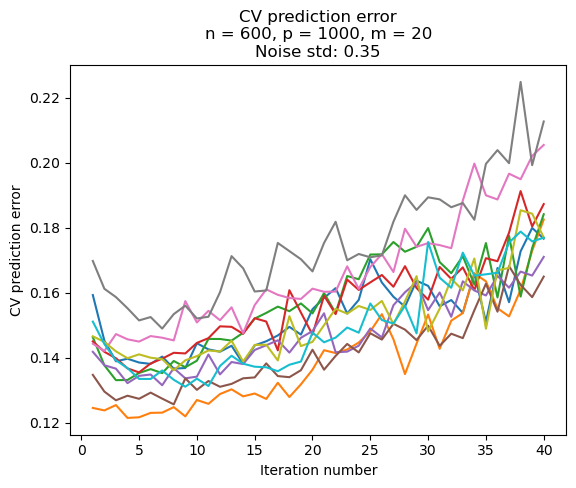

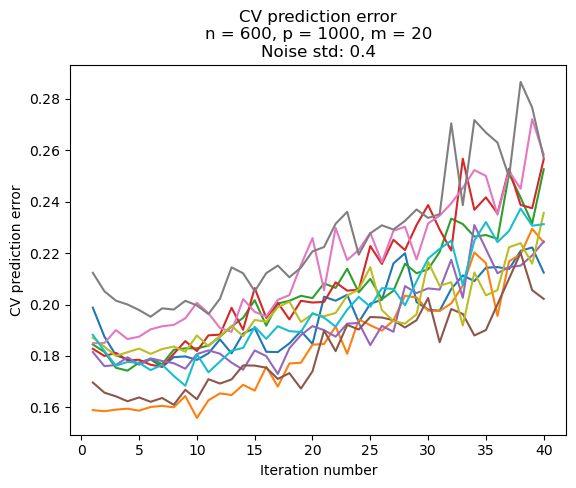

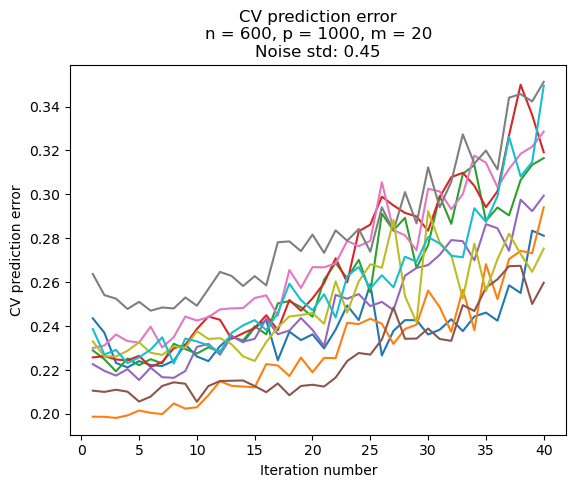

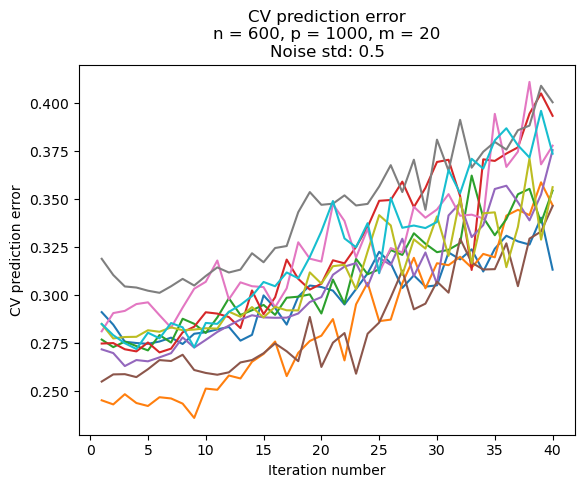

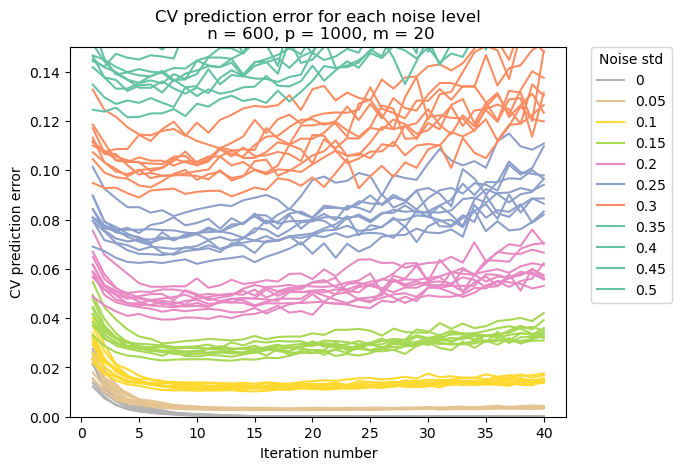

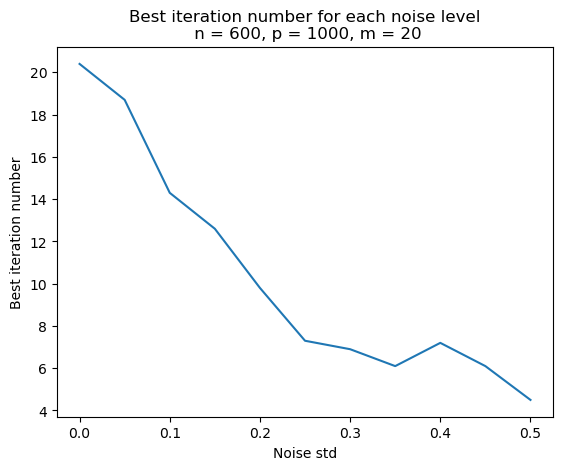

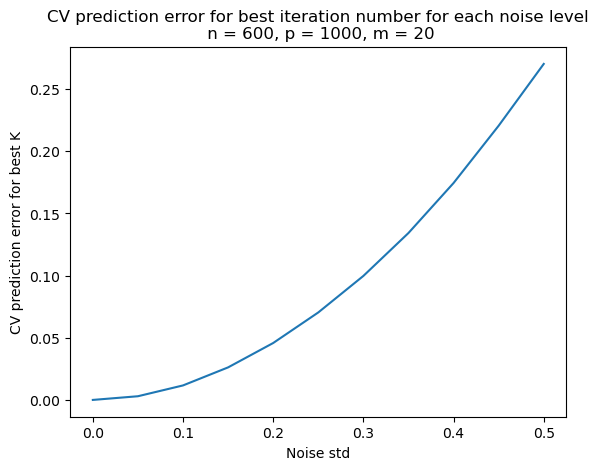

In [110]:
makeplots(res_log, sep = True, savefig = False, ylim = [0, 0.15])

In [111]:
def makeallnoiseplots(res_log, savefig = True, colnum = 3, fig_size = None, title = True):
    if not os.path.exists('./images'):
        os.makedirs('./images')
        
    # res_log can either be a object name or path to the file
    if isinstance(res_log, str):
        path = os.path.join('./memory/', res_log)
        with open(path, 'rb') as f:
            res_log = pkl.load(f)
    
    # Extract parameters
    parameters = res_log['parameters']
    noise_level_best_K = res_log['noise_level_best_K']
    noise_level_lowest_MSE = res_log['noise_level_lowest_MSE']
    
    K_lst = parameters['K_lst']
    trial_num = res_log['parameters']['trial_num']
    print('Parameters: ', parameters)
    
    # Get folder name for saving images
    imgfolderPath = str(parameters['N']) + '_' + str(parameters['d']) + '_' + str(parameters['m']) + '_' + str(parameters['trial_num']) + '_' + str(parameters['cv_num'])
    if savefig:
        if not os.path.exists('./images/' + imgfolderPath):
            os.makedirs('./images/' + imgfolderPath)
    
    # Generate plots
    ## First plot: Iteration number vs. CV prediction error for each noise level
    noise_level_lst = parameters['noise_level_lst']
    
    if not os.path.exists('./images/' + imgfolderPath + '/noise_sep'):
        os.makedirs('./images/' + imgfolderPath + '/noise_sep')

    if fig_size:
        fig, ax = plt.subplots(len(noise_level_lst) // colnum + 1, colnum, figsize = fig_size)
    else:
        fig, ax = plt.subplots(len(noise_level_lst) // colnum + 1, colnum, figsize = (10, 12))
    for i, noise_level in enumerate(noise_level_lst):
        row = int(i/colnum)
        column = i % colnum
        for j in range(trial_num):
            ax[row, column].plot(K_lst, res_log['log'][i * trial_num + j]['cv_error_lst'])
        ax[row, column].set_xlabel("Iteration number")
        ax[row, column].set_ylabel("CV prediction error")
        ax[row, column].set_title("Noise std: " + str(noise_level))  
    plt.tight_layout()
    if title:
        fig.suptitle("CV prediction error\nn = " + str(parameters['d']) + ", p = " + str(parameters['N'])+ ", m = " + str(parameters['m']), fontsize="x-large", y = 1.05)
    if savefig:
            plt.savefig('./images/' + imgfolderPath + '/noise_sep/' + 'grid.png')  
    plt.show()
  

Parameters:  {'N': 1000, 'd': 600, 'm': 20, 'noise_level_lst': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 'cv_num': 5, 'trial_num': 10, 'K_lst': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


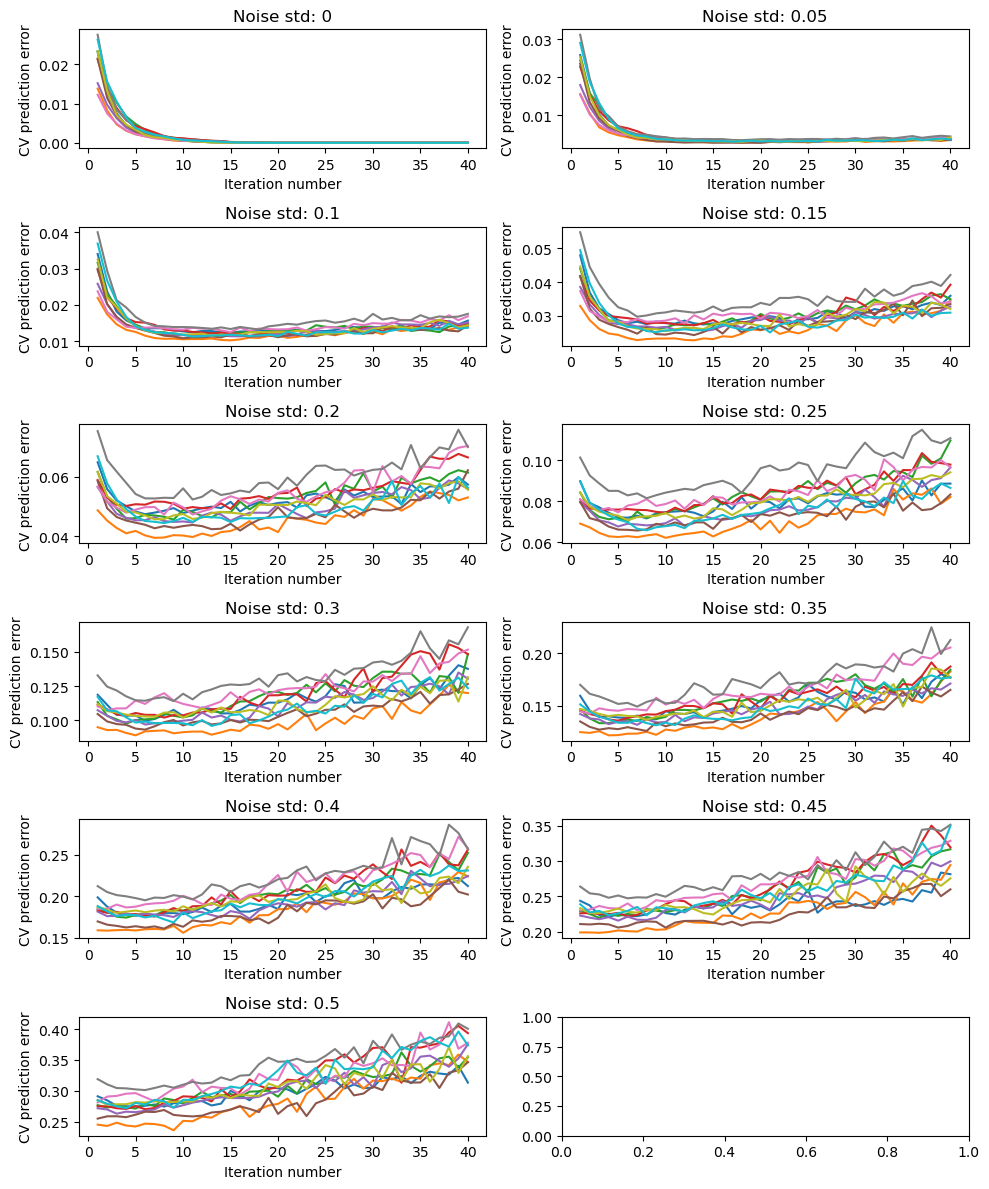

In [108]:
makeallnoiseplots(res_log, savefig = False, colnum = 2, title=False)

In [115]:
res_log['noise_level_lowest_MSE']

[7.026059914137063e-32,
 0.0029605428042293503,
 0.011655266741267493,
 0.026170558581079216,
 0.045773640137582075,
 0.07035539036921197,
 0.09972058337703592,
 0.13423976226367657,
 0.17444469946761595,
 0.220524407302474,
 0.2702401131881998]

In [22]:
# # Plotting all the results
# pkl_files = glob.glob("memory/*.pkl")
# parameter_dict_list = []
# for i in range(len(pkl_files)):
#     with open(pkl_files[i], 'rb') as f:
#         tmp = pkl.load(f)
#     makeplots(tmp, savefig = True)

### Intersting Phenomenon:
1. Best CV error almost equals to the square of noise_level